# Logic-Enhanced Foundation Models (LEFT) in ~ 100 Lines

LEFT is a unified concept learning and reasoning framework that flexibly learns concepts across domains and reasons across unseen tasks.
This notebook demonstrates how to use LEFT to learn and reason about simple shapes in 2D images, with a very small amount of code.

In [1]:
import sys
sys.path.append("/home/max/uni/LEFT/Jacinle")

import torch
import jacinle
import numpy as np
import torch.nn as nn
import jactorch

from typing import Optional, Union, List, Dict
from jacinle.config.environ_v2 import configs, set_configs
from left.domain import create_domain_from_parsing
from left.models.model import LeftModel


### Step 1: Load the simple shapes dataset.

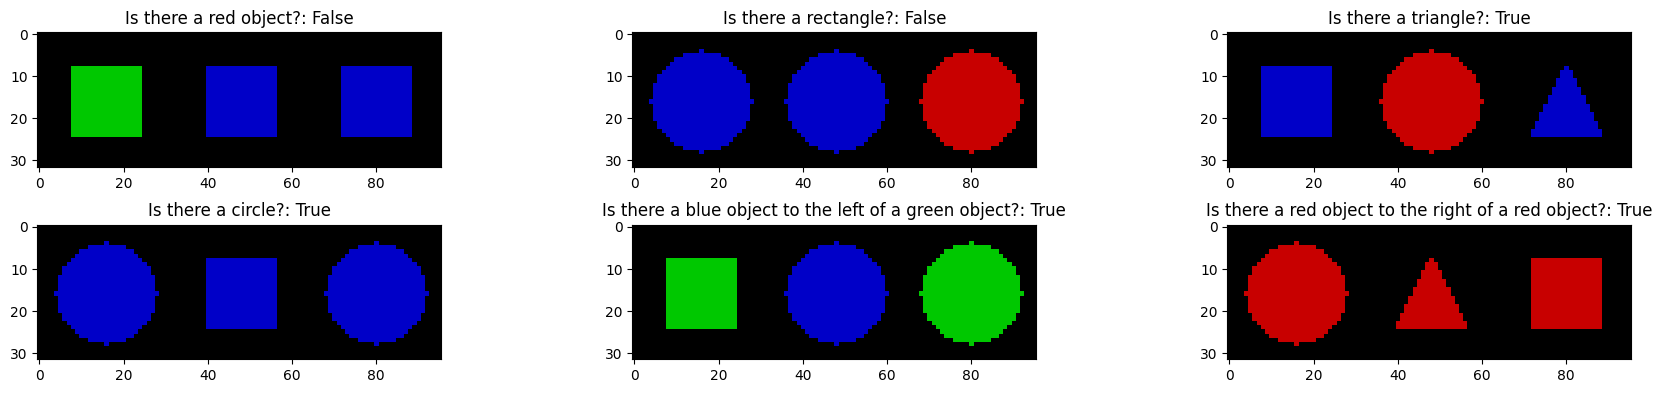

In [2]:
from concepts.benchmark.vision_language.shapes3.dataset import Shapes3Dataset
train_dataset = Shapes3Dataset(dataset_size=1024)  # create a dataset with 1024 samples
test_dataset = Shapes3Dataset(dataset_size=128)  # create a dataset with 128 samples for testing

# Now let's visualize a few samples from the dataset:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(train_dataset[i]['question'] + ': ' + str(train_dataset[i]['answer']))
plt.tight_layout()
plt.show()

### Step 2: Create the model.

Each model in LEFT is composed of:

- a visual feature extract that maps from images to a set of object features and their relational features.
- a concept embedding module that can classify objects and their relations into concepts. In this case, we will use a simple linear layer for all concepts.
- the program executor that takes a FOL program of the question as input, and generate the answer. This part is shared across all tasks, all domains, all modalities.

In [3]:
# Create the visual extractor. In this case, we will assume that we know each image is composed of three objects in a row.
# In general, we can use object detectors to extract the objects from the image.
# For each object, we will extract a 64-dimensional feature vector using a simple CNN.
# For each pair of objects, we will extract another 64-dimensional feature vector,
#   by using a simple lienar mapping from the concatenation of the two object features and their positional embeddings.

class ObjectCentricShapeEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.lenet = nn.Sequential(           # input is 1x32x32
            nn.Conv2d(3, 32, 5), nn.ReLU(),   # conv1: 32x28x28
            nn.MaxPool2d(2, 2),               # pool1: 32x14x14
            nn.Conv2d(32, 32, 5), nn.ReLU(),  # conv2: 32x10x10
            nn.MaxPool2d(2, 2),               # pool2: 32x5x5
        )
        self.fc = nn.Sequential(nn.Linear(32 * 5 * 5, 64), nn.ReLU())
        self.position_embedding = nn.Embedding(9, 64)
        self.fc2 = nn.Linear(256, 64)

    def forward(self, img):
        obj = self.forward_object(img)
        rel = self.forward_relation(obj)
        return obj, rel  # obj: [B, 3, 64], rel: [B, 3, 3, 64]

    def forward_object(self, img):
        # img = B, 3, 30, 30
        b = img.size(0)
        img = img.reshape((b, 3, 1, 32, 3, 32)).permute((0, 2, 4, 1, 3, 5)).reshape((b * 3, 3, 32, 32))
        img = self.lenet(img)
        img = img.reshape((b, 3, 32 * 25))
        img = self.fc(img)
        return img

    def forward_relation(self, object_feat):
        nr_objects = 3
        position_feature = torch.arange(nr_objects, dtype=torch.int64, device=object_feat.device)
        position_feature = self.position_embedding(position_feature)
        position_feature = position_feature.unsqueeze(0).expand(object_feat.size(0), nr_objects, 64)
        feature = torch.cat([object_feat, position_feature], dim=-1)

        feature1 = feature.unsqueeze(1).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature2 = feature.unsqueeze(2).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature = torch.cat([feature1, feature2], dim=-1)

        feature = self.fc2(feature)
        return feature

In [14]:
# Create a main model. You just need to implement the object-centric feature extractor, and a few other lines of code to processs each question in the batch.

with set_configs():
    configs.model.domain = 'shapes3'            # set to the name of the dataset
    configs.model.scene_graph = None            # set to the identifier of the scene graph extractor. In this case we will use our own implementation.
    configs.model.concept_embedding = 'linear'  # set to the identifier of the concept embedding. In this case we will use a simple linear mapping.
    configs.model.sg_dims = [None, 64, 64, 64]  # set to the dimensions of the object and relation features. In this case we will use 64-dimensional features for all of them.


class SimpleShapesModel(LeftModel):
    def __init__(self, domain, parses: Dict[str, Union[str, List[str]]], output_vocab):
        super().__init__(domain, output_vocab)

        self.parses = parses
        self.scene_graph = ObjectCentricShapeEmbedding()

    def forward(self, feed_dict):
        feed_dict = jacinle.GView(feed_dict)
        monitors, outputs = {}, {}

        f_sng = self.forward_sng(feed_dict)
        for i in range(len(feed_dict.question)):
            grounding = self.grounding_cls(f_sng[i], self, self.training, apply_relation_mask=True)
            question = feed_dict.question[i]
            raw_parsing = self.parses[question]
            raw_parsing = raw_parsing[0] if isinstance(raw_parsing, list) else raw_parsing
            # This will write to outputs['executions']
            print(raw_parsing)
            self.execute_program_from_parsing_string(question, raw_parsing, grounding, outputs)

        update_from_loss_module(monitors, outputs, self.qa_loss(outputs['executions'], feed_dict.answer, question_types=['bool' for _ in outputs['executions']]))

        if self.training:
            loss = monitors['loss/qa']
            return loss, monitors, outputs
        else:
            outputs['monitors'] = monitors
            return outputs

    def forward_sng(self, feed_dict):
        object_features, relation_features = self.scene_graph(feed_dict.image)
        all_scene_features = [{'attribute': object_features[i], 'relation': relation_features[i]} for i in range(len(object_features))]
        return all_scene_features


def update_from_loss_module(monitors, output_dict, loss_update):
    tmp_monitors, tmp_outputs = loss_update
    monitors.update(tmp_monitors)
    output_dict.update(tmp_outputs)

### Step 3: Training and evaluation.

In [10]:
language_to_program = {train_dataset[i]['question']: train_dataset[i]['program'] for i in range(len(train_dataset))}
language_to_program.update({test_dataset[i]['question']: test_dataset[i]['program'] for i in range(len(test_dataset))})

# In this example code, we will not be running GPT to parse the questions. Instead, we just use the groundtruth programs that come with the dataset.
# What you need is simple a dictionary that maps each question to its program.
# Visualize the first 6 questions and their programs.

for i in range(6):
    question = train_dataset[i]['question']
    print(question)
    print(language_to_program[question])

Is there a red object?
exists(Object, lambda x: red(x))
Is there a rectangle?
exists(Object, lambda x: rectangle(x))
Is there a triangle?
exists(Object, lambda x: triangle(x))
Is there a circle?
exists(Object, lambda x: circle(x))
Is there a blue object to the left of a green object?
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and green(y)))
Is there a red object to the right of a red object?
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and red(y)))


In [11]:
# Create a domain using all the parsed programs. It will automatically extract all concepts and relations from the programs.
domain = create_domain_from_parsing(language_to_program)

Creating domain from parsings: 100%|################################################| 78/78 [00:00<00:00, 3815.09it/s]


In [12]:
# Visualize the domain. You can see that it has extracted all the concepts and relations from the programs.
domain.print_summary()

TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    red_Object(#0: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    triangle_Object(#0: Object) -> bool
    circle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    green_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool


In [22]:
func = domain.get_function("green_Object")
arg = func.arguments[0]
arg.typename

'Object'

In [15]:
# Define a helper function to update the meters.
def update_meters(meters, monitors, prefix: Optional[str] = None):
    for k in list(monitors.keys()):
        if k + '/n' in monitors:
            meters.update({k: monitors[k]}, n=monitors[k + '/n'], prefix=prefix)
            del monitors[k]
            del monitors[k + '/n']

    meters.update(monitors, prefix=prefix)

# Build the domain.
domain = create_domain_from_parsing(language_to_program)
domain.print_summary()

# Build the model.
model = SimpleShapesModel(domain, language_to_program, output_vocab=None)  # output vocab is not used (Boolean only)

# Build the optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
group_meters = jacinle.GroupMeters()

nr_epochs = 8
for i in range(1, nr_epochs + 1):
    dataloader = train_dataset.make_dataloader(batch_size=16, shuffle=True, drop_last=True, nr_workers=0)
    model.train()
    group_meters.reset()
    for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {}'.format(i)):
        loss, monitors, outputs = model(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_meters(group_meters, {k: float(v) for k, v in monitors.items()})
        jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i}', compressed=True))

    # print(group_meters.format_simple(f'Epoch {i}', compressed=False))

    dataloader = test_dataset.make_dataloader(batch_size=16, shuffle=False, drop_last=False, nr_workers=0)
    model.eval()
    group_meters.reset()
    with torch.no_grad():
        for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {} (test)'.format(i)):
            outputs = model(data)
            update_meters(group_meters, {k: float(v) for k, v in outputs['monitors'].items()})
            jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i} (test)', compressed=True))

    print(group_meters.format_simple(f'Epoch {i} (test)', compressed=False))

Creating domain from parsings: 100%|################################################| 78/78 [00:00<00:00, 6944.95it/s]
13 13:16:45 Function equal automatically registered.
13 13:16:45 Function greater_than automatically registered.
13 13:16:45 Function less_than automatically registered.


TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    red_Object(#0: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    triangle_Object(#0: Object) -> bool
    circle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    green_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool


Epoch 1 acc/qa=0.375000 acc/qa/bool=0.375000 acc/qa_succ_exec=0.375000 acc/success_exec=1.000000 loss/qa=0.727059:   5

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute

Epoch 1 acc/qa=0.460938 acc/qa/bool=0.460938 acc/qa_succ_exec=0.460938 acc/success_exec=1.000000 loss/qa=0.710160:  11

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribu

Epoch 1 acc/qa=0.512500 acc/qa/bool=0.512500 acc/qa_succ_exec=0.512500 acc/success_exec=1.000000 loss/qa=0.703826:  14

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'a

Epoch 1 acc/qa=0.514423 acc/qa/bool=0.514423 acc/qa_succ_exec=0.514423 acc/success_exec=1.000000 loss/qa=0.698094:  19

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'at

Epoch 1 acc/qa=0.522321 acc/qa/bool=0.522321 acc/qa_succ_exec=0.522321 acc/success_exec=1.000000 loss/qa=0.699902:  20

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Ob

Epoch 1 acc/qa=0.555921 acc/qa/bool=0.555921 acc/qa_succ_exec=0.555921 acc/success_exec=1.000000 loss/qa=0.683036:  28

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', '

Epoch 1 acc/qa=0.556250 acc/qa/bool=0.556250 acc/qa_succ_exec=0.556250 acc/success_exec=1.000000 loss/qa=0.692888:  30

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 

Epoch 1 acc/qa=0.559783 acc/qa/bool=0.559783 acc/qa_succ_exec=0.559783 acc/success_exec=1.000000 loss/qa=0.692552:  34

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Obj

Epoch 1 acc/qa=0.567708 acc/qa/bool=0.567708 acc/qa_succ_exec=0.567708 acc/success_exec=1.000000 loss/qa=0.685193:  38

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and green(y)))


Epoch 1 acc/qa=0.557870 acc/qa/bool=0.557870 acc/qa_succ_exec=0.557870 acc/success_exec=1.000000 loss/qa=0.680318:  42

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x

Epoch 1 acc/qa=0.568182 acc/qa/bool=0.568182 acc/qa_succ_exec=0.568182 acc/success_exec=1.000000 loss/qa=0.660386:  52

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Obje

Epoch 1 acc/qa=0.584936 acc/qa/bool=0.584936 acc/qa_succ_exec=0.584936 acc/success_exec=1.000000 loss/qa=0.648129:  61

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - rig

Epoch 1 acc/qa=0.596591 acc/qa/bool=0.596591 acc/qa_succ_exec=0.596591 acc/success_exec=1.000000 loss/qa=0.644571:  67

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object

Epoch 1 acc/qa=0.608073 acc/qa/bool=0.608073 acc/qa_succ_exec=0.608073 acc/success_exec=1.000000 loss/qa=0.634799:  75

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribu

Epoch 1 acc/qa=0.619213 acc/qa/bool=0.619213 acc/qa_succ_exec=0.619213 acc/success_exec=1.000000 loss/qa=0.622879:  84

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_out

Epoch 1 acc/qa=0.628178 acc/qa/bool=0.628178 acc/qa_succ_exec=0.628178 acc/success_exec=1.000000 loss/qa=0.616806:  91

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green

Epoch 1 acc/qa=0.632812 acc/qa/bool=0.632812 acc/qa_succ_exec=0.632812 acc/success_exec=1.000000 loss/qa=0.608212: 100


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim':

Epoch 1 (test):   0%|                                                                           | 0/8 [00:00<?, ?it/s]

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 1 (test) acc/qa=0.726562 acc/qa/bool=0.726562 acc/qa_succ_exec=0.726562 acc/success_exec=1.000000: 100%|#| 8/8 [


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(

Epoch 2:   0%|                                                                                 | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Ob

Epoch 2 acc/qa=0.791667 acc/qa/bool=0.791667 acc/qa_succ_exec=0.791667 acc/success_exec=1.000000 loss/qa=0.443215:   3

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', '

Epoch 2 acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 acc/success_exec=1.000000 loss/qa=0.470301:   6

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_

Epoch 2 acc/qa=0.757812 acc/qa/bool=0.757812 acc/qa_succ_exec=0.757812 acc/success_exec=1.000000 loss/qa=0.447827:  11

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 6

Epoch 2 acc/qa=0.762500 acc/qa/bool=0.762500 acc/qa_succ_exec=0.762500 acc/success_exec=1.000000 loss/qa=0.426307:  14

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 

Epoch 2 acc/qa=0.754464 acc/qa/bool=0.754464 acc/qa_succ_exec=0.754464 acc/success_exec=1.000000 loss/qa=0.410024:  20

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_o

Epoch 2 acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 acc/success_exec=1.000000 loss/qa=0.412515:  22

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - 

Epoch 2 acc/qa=0.768750 acc/qa/bool=0.768750 acc/qa_succ_exec=0.768750 acc/success_exec=1.000000 loss/qa=0.403854:  30

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object

Epoch 2 acc/qa=0.776786 acc/qa/bool=0.776786 acc/qa_succ_exec=0.776786 acc/success_exec=1.000000 loss/qa=0.392390:  31

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': Non

Epoch 2 acc/qa=0.782500 acc/qa/bool=0.782500 acc/qa_succ_exec=0.782500 acc/success_exec=1.000000 loss/qa=0.394746:  39

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'att

Epoch 2 acc/qa=0.781250 acc/qa/bool=0.781250 acc/qa_succ_exec=0.781250 acc/success_exec=1.000000 loss/qa=0.395048:  39

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object 

Epoch 2 acc/qa=0.789583 acc/qa/bool=0.789583 acc/qa_succ_exec=0.789583 acc/success_exec=1.000000 loss/qa=0.386588:  45

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_O

Epoch 2 acc/qa=0.790323 acc/qa/bool=0.790323 acc/qa_succ_exec=0.790323 acc/success_exec=1.000000 loss/qa=0.388268:  48

2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circl

Epoch 2 acc/qa=0.785714 acc/qa/bool=0.785714 acc/qa_succ_exec=0.785714 acc/success_exec=1.000000 loss/qa=0.387548:  53

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: trian

Epoch 2 acc/qa=0.784722 acc/qa/bool=0.784722 acc/qa_succ_exec=0.784722 acc/success_exec=1.000000 loss/qa=0.387851:  55

2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Objec

Epoch 2 acc/qa=0.770312 acc/qa/bool=0.770312 acc/qa_succ_exec=0.770312 acc/success_exec=1.000000 loss/qa=0.399464:  62

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Ob

Epoch 2 acc/qa=0.774390 acc/qa/bool=0.774390 acc/qa_succ_exec=0.774390 acc/success_exec=1.000000 loss/qa=0.398321:  62

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - ri

Epoch 2 acc/qa=0.779167 acc/qa/bool=0.779167 acc/qa_succ_exec=0.779167 acc/success_exec=1.000000 loss/qa=0.391654:  69

2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Ob

Epoch 2 acc/qa=0.778533 acc/qa/bool=0.778533 acc/qa_succ_exec=0.778533 acc/success_exec=1.000000 loss/qa=0.391919:  72

2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'conc

Epoch 2 acc/qa=0.782500 acc/qa/bool=0.782500 acc/qa_succ_exec=0.782500 acc/success_exec=1.000000 loss/qa=0.385874:  77

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim

Epoch 2 acc/qa=0.793182 acc/qa/bool=0.793182 acc/qa_succ_exec=0.793182 acc/success_exec=1.000000 loss/qa=0.371816:  86

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_

Epoch 2 acc/qa=0.805328 acc/qa/bool=0.805328 acc/qa_succ_exec=0.805328 acc/success_exec=1.000000 loss/qa=0.357784:  95

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, '

Epoch 2 acc/qa=0.810547 acc/qa/bool=0.810547 acc/qa_succ_exec=0.810547 acc/success_exec=1.000000 loss/qa=0.352688: 100


exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_

Epoch 2 (test) acc/qa=0.912500 acc/qa/bool=0.912500 acc/qa_succ_exec=0.912500 acc/success_exec=1.000000:  62%|6| 5/8 [

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 2 (test) acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000: 100%|#| 8/8 [


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 

Epoch 3:   0%|                                                                                 | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Objec

Epoch 3 acc/qa=0.916667 acc/qa/bool=0.916667 acc/qa_succ_exec=0.916667 acc/success_exec=1.000000 loss/qa=0.208109:   5

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 

Epoch 3 acc/qa=0.925000 acc/qa/bool=0.925000 acc/qa_succ_exec=0.925000 acc/success_exec=1.000000 loss/qa=0.204760:   6

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Obj

Epoch 3 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.179635:   9

2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Obj

Epoch 3 acc/qa=0.944444 acc/qa/bool=0.944444 acc/qa_succ_exec=0.944444 acc/success_exec=1.000000 loss/qa=0.175215:  14

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - tri

Epoch 3 acc/qa=0.950000 acc/qa/bool=0.950000 acc/qa_succ_exec=0.950000 acc/success_exec=1.000000 loss/qa=0.176466:  14

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exis

Epoch 3 acc/qa=0.948864 acc/qa/bool=0.948864 acc/qa_succ_exec=0.948864 acc/success_exec=1.000000 loss/qa=0.174613:  16

2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': []

Epoch 3 acc/qa=0.946429 acc/qa/bool=0.946429 acc/qa_succ_exec=0.946429 acc/success_exec=1.000000 loss/qa=0.163645:  20

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - t

Epoch 3 acc/qa=0.950000 acc/qa/bool=0.950000 acc/qa_succ_exec=0.950000 acc/success_exec=1.000000 loss/qa=0.161092:  23

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 

Epoch 3 acc/qa=0.949219 acc/qa/bool=0.949219 acc/qa_succ_exec=0.949219 acc/success_exec=1.000000 loss/qa=0.163155:  23

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'ci

Epoch 3 acc/qa=0.950000 acc/qa/bool=0.950000 acc/qa_succ_exec=0.950000 acc/success_exec=1.000000 loss/qa=0.167684:  30

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 

Epoch 3 acc/qa=0.949405 acc/qa/bool=0.949405 acc/qa_succ_exec=0.949405 acc/success_exec=1.000000 loss/qa=0.164824:  33

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - ci

Epoch 3 acc/qa=0.951705 acc/qa/bool=0.951705 acc/qa_succ_exec=0.951705 acc/success_exec=1.000000 loss/qa=0.161972:  33

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Ob

Epoch 3 acc/qa=0.952500 acc/qa/bool=0.952500 acc/qa_succ_exec=0.952500 acc/success_exec=1.000000 loss/qa=0.157780:  38

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 

Epoch 3 acc/qa=0.951923 acc/qa/bool=0.951923 acc/qa_succ_exec=0.951923 acc/success_exec=1.000000 loss/qa=0.156464:  39

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Objec

Epoch 3 acc/qa=0.953704 acc/qa/bool=0.953704 acc/qa_succ_exec=0.953704 acc/success_exec=1.000000 loss/qa=0.152231:  42

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obj

Epoch 3 acc/qa=0.949597 acc/qa/bool=0.949597 acc/qa_succ_exec=0.949597 acc/success_exec=1.000000 loss/qa=0.145450:  47

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - l

Epoch 3 acc/qa=0.951172 acc/qa/bool=0.951172 acc/qa_succ_exec=0.951172 acc/success_exec=1.000000 loss/qa=0.141501:  48

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'att

Epoch 3 acc/qa=0.953571 acc/qa/bool=0.953571 acc/qa_succ_exec=0.953571 acc/success_exec=1.000000 loss/qa=0.134430:  53

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Objec

Epoch 3 acc/qa=0.957237 acc/qa/bool=0.957237 acc/qa_succ_exec=0.957237 acc/success_exec=1.000000 loss/qa=0.127455:  58

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_O

Epoch 3 acc/qa=0.958841 acc/qa/bool=0.958841 acc/qa_succ_exec=0.958841 acc/success_exec=1.000000 loss/qa=0.122619:  62

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_d

Epoch 3 acc/qa=0.960756 acc/qa/bool=0.960756 acc/qa_succ_exec=0.960756 acc/success_exec=1.000000 loss/qa=0.120031:  66

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'gr

Epoch 3 acc/qa=0.963315 acc/qa/bool=0.963315 acc/qa_succ_exec=0.963315 acc/success_exec=1.000000 loss/qa=0.115086:  70

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object',

Epoch 3 acc/qa=0.965561 acc/qa/bool=0.965561 acc/qa_succ_exec=0.965561 acc/success_exec=1.000000 loss/qa=0.109666:  75

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attrib

Epoch 3 acc/qa=0.967548 acc/qa/bool=0.967548 acc/qa_succ_exec=0.967548 acc/success_exec=1.000000 loss/qa=0.104017:  80

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'at

Epoch 3 acc/qa=0.969318 acc/qa/bool=0.969318 acc/qa_succ_exec=0.969318 acc/success_exec=1.000000 loss/qa=0.099117:  84

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_inpu

Epoch 3 acc/qa=0.970395 acc/qa/bool=0.970395 acc/qa_succ_exec=0.970395 acc/success_exec=1.000000 loss/qa=0.096448:  89

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - to

Epoch 3 acc/qa=0.971398 acc/qa/bool=0.971398 acc/qa_succ_exec=0.971398 acc/success_exec=1.000000 loss/qa=0.093715:  91

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 -

Epoch 3 acc/qa=0.972782 acc/qa/bool=0.972782 acc/qa_succ_exec=0.972782 acc/success_exec=1.000000 loss/qa=0.090140:  95

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attri

Epoch 3 acc/qa=0.972656 acc/qa/bool=0.972656 acc/qa_succ_exec=0.972656 acc/success_exec=1.000000 loss/qa=0.088777: 100


exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Objec

Epoch 3 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:   0%| | 0/8 [

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 3 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  75%|7| 6/8 [

2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object'

Epoch 3 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000: 100%|#| 8/8 [


exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim

Epoch 4:   0%|                                                                                 | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64,

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.003172:   0

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64,

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.008643:   5

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.012227:   6

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_O

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.011494:   9

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': 

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.013673:  14

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Obj

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.013249:  16

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_di

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.011966:  19

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Obje

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.011458:  20

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_di

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.009924:  28

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'at

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.010033:  30

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.009780:  38

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - le

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.008985:  44

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.008793:  47

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'at

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.008187:  52

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_ou

Epoch 4 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.008169:  53

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_O

Epoch 4 acc/qa=0.998397 acc/qa/bool=0.998397 acc/qa_succ_exec=0.998397 acc/success_exec=1.000000 loss/qa=0.009304:  61

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_O

Epoch 4 acc/qa=0.998476 acc/qa/bool=0.998476 acc/qa_succ_exec=0.998476 acc/success_exec=1.000000 loss/qa=0.009148:  62

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue

Epoch 4 acc/qa=0.998611 acc/qa/bool=0.998611 acc/qa_succ_exec=0.998611 acc/success_exec=1.000000 loss/qa=0.008943:  69

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - re

Epoch 4 acc/qa=0.998641 acc/qa/bool=0.998641 acc/qa_succ_exec=0.998641 acc/success_exec=1.000000 loss/qa=0.008980:  70

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'b

Epoch 4 acc/qa=0.998750 acc/qa/bool=0.998750 acc/qa_succ_exec=0.998750 acc/success_exec=1.000000 loss/qa=0.008937:  77

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attrib

Epoch 4 acc/qa=0.998798 acc/qa/bool=0.998798 acc/qa_succ_exec=0.998798 acc/success_exec=1.000000 loss/qa=0.008905:  80

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_O

Epoch 4 acc/qa=0.998884 acc/qa/bool=0.998884 acc/qa_succ_exec=0.998884 acc/success_exec=1.000000 loss/qa=0.008580:  86

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left

Epoch 4 acc/qa=0.998922 acc/qa/bool=0.998922 acc/qa_succ_exec=0.998922 acc/success_exec=1.000000 loss/qa=0.008368:  89

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim

Epoch 4 acc/qa=0.998992 acc/qa/bool=0.998992 acc/qa_succ_exec=0.998992 acc/success_exec=1.000000 loss/qa=0.007959:  95

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Objec

Epoch 4 acc/qa=0.999008 acc/qa/bool=0.999008 acc/qa_succ_exec=0.999008 acc/success_exec=1.000000 loss/qa=0.007887:  98

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_

Epoch 4 acc/qa=0.999023 acc/qa/bool=0.999023 acc/qa_succ_exec=0.999023 acc/success_exec=1.000000 loss/qa=0.007778: 100
Epoch 4 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  75%|7| 6/8 [

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 4 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000: 100%|#| 8/8 [


exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim

Epoch 5:   0%|                                                                                 | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Obj

Epoch 5 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.001535:   5

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attr

Epoch 5 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.002349:   6

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Obj

Epoch 5 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.002120:  11

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Objec

Epoch 5 acc/qa=0.993750 acc/qa/bool=0.993750 acc/qa_succ_exec=0.993750 acc/success_exec=1.000000 loss/qa=0.030638:  14

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 6

Epoch 5 acc/qa=0.994318 acc/qa/bool=0.994318 acc/qa_succ_exec=0.994318 acc/success_exec=1.000000 loss/qa=0.029742:  16

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_

Epoch 5 acc/qa=0.995536 acc/qa/bool=0.995536 acc/qa_succ_exec=0.995536 acc/success_exec=1.000000 loss/qa=0.023872:  20

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - t

Epoch 5 acc/qa=0.995833 acc/qa/bool=0.995833 acc/qa_succ_exec=0.995833 acc/success_exec=1.000000 loss/qa=0.022436:  23

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object'

Epoch 5 acc/qa=0.996324 acc/qa/bool=0.996324 acc/qa_succ_exec=0.996324 acc/success_exec=1.000000 loss/qa=0.021775:  25

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', '

Epoch 5 acc/qa=0.996875 acc/qa/bool=0.996875 acc/qa_succ_exec=0.996875 acc/success_exec=1.000000 loss/qa=0.021363:  30

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object

Epoch 5 acc/qa=0.997024 acc/qa/bool=0.997024 acc/qa_succ_exec=0.997024 acc/success_exec=1.000000 loss/qa=0.022167:  33

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Ob

Epoch 5 acc/qa=0.997159 acc/qa/bool=0.997159 acc/qa_succ_exec=0.997159 acc/success_exec=1.000000 loss/qa=0.023677:  33

2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'c

Epoch 5 acc/qa=0.997596 acc/qa/bool=0.997596 acc/qa_succ_exec=0.997596 acc/success_exec=1.000000 loss/qa=0.025319:  39

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute

Epoch 5 acc/qa=0.997685 acc/qa/bool=0.997685 acc/qa_succ_exec=0.997685 acc/success_exec=1.000000 loss/qa=0.024469:  42

2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['re

Epoch 5 acc/qa=0.997917 acc/qa/bool=0.997917 acc/qa_succ_exec=0.997917 acc/success_exec=1.000000 loss/qa=0.023826:  47

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Ob

Epoch 5 acc/qa=0.997984 acc/qa/bool=0.997984 acc/qa_succ_exec=0.997984 acc/success_exec=1.000000 loss/qa=0.024035:  47

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right

Epoch 5 acc/qa=0.998214 acc/qa/bool=0.998214 acc/qa_succ_exec=0.998214 acc/success_exec=1.000000 loss/qa=0.021798:  53

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Objec

Epoch 5 acc/qa=0.998264 acc/qa/bool=0.998264 acc/qa_succ_exec=0.998264 acc/success_exec=1.000000 loss/qa=0.021297:  56

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim':

Epoch 5 acc/qa=0.998437 acc/qa/bool=0.998437 acc/qa_succ_exec=0.998437 acc/success_exec=1.000000 loss/qa=0.019512:  61

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object',

Epoch 5 acc/qa=0.998476 acc/qa/bool=0.998476 acc/qa_succ_exec=0.998476 acc/success_exec=1.000000 loss/qa=0.019065:  62

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 

Epoch 5 acc/qa=0.998611 acc/qa/bool=0.998611 acc/qa_succ_exec=0.998611 acc/success_exec=1.000000 loss/qa=0.017878:  70

2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Obj

Epoch 5 acc/qa=0.998775 acc/qa/bool=0.998775 acc/qa_succ_exec=0.998775 acc/success_exec=1.000000 loss/qa=0.016028:  80

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object -

Epoch 5 acc/qa=0.998864 acc/qa/bool=0.998864 acc/qa_succ_exec=0.998864 acc/success_exec=1.000000 loss/qa=0.014965:  84

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', '

Epoch 5 acc/qa=0.998922 acc/qa/bool=0.998922 acc/qa_succ_exec=0.998922 acc/success_exec=1.000000 loss/qa=0.014269:  89

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object

Epoch 5 acc/qa=0.998992 acc/qa/bool=0.998992 acc/qa_succ_exec=0.998992 acc/success_exec=1.000000 loss/qa=0.013497:  95

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - 

Epoch 5 acc/qa=0.999023 acc/qa/bool=0.999023 acc/qa_succ_exec=0.999023 acc/success_exec=1.000000 loss/qa=0.013125: 100


exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Objec

Epoch 5 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  62%|6| 5/8 [

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 5 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  75%|7| 6/8 [

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_

Epoch 5 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000: 100%|#| 8/8 [


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Objec

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.001302:   5

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.001163:   5

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object'

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000930:   9

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - tr

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.001037:  11

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: recta

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.001068:  16

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_di

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.001014:  19

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000999:  19

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.001005:  22

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'gr

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000984:  22

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000951:  25

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blu

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000931:  25

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object'

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000899:  33

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', '

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000877:  34

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object',

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000838:  42

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000821:  42

2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'ci

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000787:  48

2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['re

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000778:  52

2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': 

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000745:  56

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000736:  58

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'bl

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000712:  66

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_O

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000680:  70

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000666:  73

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000639:  80

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Objec

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000634:  81

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - re

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000626:  86

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim'

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000614:  89

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000592:  95

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'at

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000587:  98

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exist

Epoch 6 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000583: 100
Epoch 6 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  50%|5| 4/8 [

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 6 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  62%|6| 5/8 [

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'att

Epoch 6 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000: 100%|#| 8/8 [


exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'bl

Epoch 7:   0%|                                                                                 | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obj

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000329:   3

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Obj

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000276:   5

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'bl

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000285:   8

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000281:  12

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_ou

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000298:  14

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Obje

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000297:  17

2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object'

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000294:  19

2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'conc

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000298:  22

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Obje

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000297:  23

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribut

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000277:  28

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_inpu

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000267:  31

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim':

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000264:  33

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000260:  38

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_O

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000257:  41

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object',

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000254:  42

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attrib

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000254:  47

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000246:  50

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Ob

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000245:  52

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Obje

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000244:  55

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim':

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000245:  59

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rec

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000243:  59

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000242:  64

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000240:  66

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Ob

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000235:  69

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribut

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000234:  73

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_di

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000232:  78

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim'

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000241:  78

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Obj

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000239:  83

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object -

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000238:  84

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000235:  89

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', '

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000233:  92

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blu

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000230:  95

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Obje

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000230:  98

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle

Epoch 7 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000230: 100
Epoch 7 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  12%|1| 1/8 [

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 7 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  62%|6| 5/8 [

2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_

Epoch 7 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000: 100%|#| 8/8 [


2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'tr

Epoch 8:   0%|                                                                                 | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribu

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000146:   2

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_O

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000175:   5

2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'tr

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000184:   8

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_O

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000184:   9

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object',

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000179:   9

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'a

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000180:  14

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_outpu

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000176:  16

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribut

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000167:  19

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000171:  19

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object'

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000175:  23

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - righ

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000172:  25

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: red

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000174:  28

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Objec

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000173:  28

2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': []

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000176:  33

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circl

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000175:  33

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'bl

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000170:  38

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000182:  42

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'b

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000181:  42

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attri

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000180:  47

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000174:  52

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object'

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000174:  53

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'b

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000174:  56

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'att

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000170:  58

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000170:  61

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'gr

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000169:  62

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000168:  67

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_O

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000169:  70

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000166:  72

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_O

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000167:  77

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'bl

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000165:  80

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 6

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000164:  81

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'b

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000163:  86

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'b

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000161:  89

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obj

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000160:  91

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000157:  95

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object'

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000157:  98

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - rig

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.000156: 100


exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])


Epoch 8 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:   0%| | 0/8 [

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 8 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000:  62%|6| 5/8 [

2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'righ

Epoch 8 (test) acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000: 100%|#| 8/8 [

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['red_Object', 'rectangle_Object', 'triangle_Object', 'circle_Object', 'blue_Object', 'green_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - 

### Step 4: Visualize the results.

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])


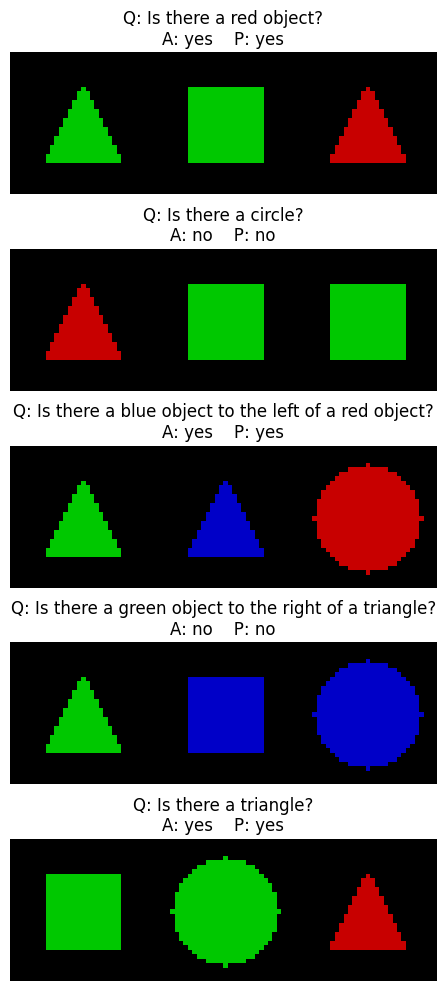

In [9]:
model.eval()

def get_answer(model, image: torch.Tensor, question: str):
    with torch.no_grad():
        outputs = model({'image': image.unsqueeze(0), 'question': [question], 'answer': [None]})
    return outputs['pred_answers'][0]


plt.figure(figsize=(5, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    image, question, answer = test_dataset[i]['image'], test_dataset[i]['question'], test_dataset[i]['answer']
    answer = 'yes' if answer else 'no'
    pred_answer = get_answer(model, image, question)
    plt.imshow(image.permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(f'Q: {question}\nA: {answer}    P: {pred_answer}')
    plt.axis('off')

plt.tight_layout()
plt.show()